<a href="https://colab.research.google.com/github/woooon79/GAN/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')      

Mounted at /content/drive/


#Download dataset

In [ ]:
!mkdir -p /content/drive/MyDrive/datasets2
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
!unzip apple2orange.zip -d /content/drive/MyDrive/datasets2/

In [ ]:
!mkdir -p /content/drive/MyDrive/CycleGAN/apple2orange

#Set dataset

In [ ]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


class ImageDataset(Dataset):
  def __init__(self,root,transforms_=None,unaligned=False,mode='train'):
    self.transform=transforms.Compose(transforms_)
    self.unaligned=unaligned

    self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
    self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))



  def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        

        return {'A': item_A, 'B': item_B,'A_name':self.files_A[index % len(self.files_A)],'B_name':self.files_B[index % len(self.files_B)]}


  def __len__(self):
        return max(len(self.files_A), len(self.files_B))

#Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#detail 보존가능, 고해상도 처리
class ResidualBlock(nn.Module):
  def __init__(self,in_features):
    super(ResidualBlock,self).__init__()

    conv_block = [ nn.ReflectionPad2d(1), #입력 경계의 반사를 사용하여 입력 텐서를 채움
                   nn.Conv2d(in_features, in_features, 3), 
                   nn.InstanceNorm2d(in_features),# Batch version normalizes all images across the batch and spatial locations (in the CNN case, in the ordinary case it's different); instance version normalizes each element of the batch independently, (i.e., across spatial locations only.)
                   nn.ReLU(inplace=True),
                   nn.ReflectionPad2d(1),
                   nn.Conv2d(in_features, in_features, 3), 
                   nn.InstanceNorm2d(in_features)]

    self.conv_block=nn.Sequential(*conv_block)

  def forward(self,x):
    return x+self.conv_block(x)




class Generator(nn.Module):
  def __init__(self,in_ch,out_ch,n_residual_blocks=9):
    super(Generator,self).__init__()

    #Initial convolution block
    model =[ nn.ReflectionPad2d(3),
             nn.Conv2d(in_ch,64,7),
             nn.InstanceNorm2d(64),
             nn.ReLU(inplace=True)]

     

    #Downsampling
    in_features=64
    out_features=64*2

    for _ in range(2):
      model+=[ nn.Conv2d(in_features,out_features,3,stride=2,padding=1),
               nn.InstanceNorm2d(out_features), #128
               nn.ReLU(inplace=True)]
      in_features=out_features #128
      out_features=in_features*2 #256

    for _ in range(n_residual_blocks):
      model += [ResidualBlock(in_features)]


    #Upsampling
    out_features=in_features//2
    for _ in range(2):
      model+=[ nn.ConvTranspose2d(in_features,out_features,3,stride=2,padding=1,output_padding=1),
               nn.InstanceNorm2d(out_features),
               nn.ReLU(inplace=True)]
      in_features=out_features
      out_features=in_features//2



    #Output layer
    model +=[ nn.ReflectionPad2d(3),
             nn.Conv2d(64,out_ch,7),
             nn.Tanh()]

    self.model=nn.Sequential(*model)



  def forward(self,x):
    x=self.model(x)
    return x


class Discriminator(nn.Module):
  def __init__(self,input_ch):
    super(Discriminator,self).__init__()

    model =[
            nn.Conv2d(input_ch,64,4,stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
    ]

    model +=[
             nn.Conv2d(64,128,4,stride=2,padding=1),
             nn.InstanceNorm2d(128),
             nn.LeakyReLU(0.2,inplace=True)
    ]

    model +=[
             nn.Conv2d(128,256,4,stride=2,padding=1),
             nn.InstanceNorm2d(256),
             nn.LeakyReLU(0.2,inplace=True)
    ]


    model +=[
             nn.Conv2d(256,512,4,padding=1),
             nn.InstanceNorm2d(512),
             nn.LeakyReLU(0.2,inplace=True)
    ]

    model+=[nn.Conv2d(512,1,4,padding=1)]
    self.model=nn.Sequential(*model)


  def forward(self,x):
    x=self.model(x)
    return F.avg_pool2d(x,x.size()[2:]).view(x.size()[0],-1)


In [ ]:
def get_fm_loss(real_feats, fake_feats, criterion):
    losses = 0
    for real_feat, fake_feat in zip(real_feats, fake_feats):
        l2 = (real_feat.mean(0) - fake_feat.mean(0)) * (real_feat.mean(0) - fake_feat.mean(0))
        loss = criterion( l2, Variable( torch.ones( l2.size() ) ).cuda() )
        losses += loss

    return losses

In [ ]:
class Discriminator2(nn.Module):
    def __init__(self,input_ch):

        super(Discriminator2, self).__init__()
        self.conv1 = nn.Conv2d(input_ch,64,4,stride=2,padding=1)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64,128,4,stride=2,padding=1)
        self.in2 = nn.InstanceNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(128,256,4,stride=2,padding=1)
        self.in3 = nn.InstanceNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        
         #nn.Conv2d(256,512,4,padding=1) cyclegan 에선 stride=1
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, stride=2, padding=1, bias=False)
        self.in4 = nn.InstanceNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)

        self.conv5 = nn.Conv2d(512,1,4,padding=1)



    def forward(self, input):
        conv1 = self.conv1( input )
        relu1 = self.relu1( conv1 )

        conv2 = self.conv2( relu1 )
        bn2 = self.in2( conv2 )
        relu2 = self.relu2( bn2 )

        conv3 = self.conv3( relu2 )
        bn3 = self.in3( conv3 )
        relu3 = self.relu3( bn3 )

        conv4 = self.conv4( relu3 )
        bn4 = self.in4( conv4 )
        relu4 = self.relu4( bn4 )

        conv5 = self.conv5( relu4 )

        output=F.avg_pool2d(conv5,conv5.size()[2:]).view(conv5.size()[0],-1)

        return output, [relu2, relu3, relu4]

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [ ]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


In [ ]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:

def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3*3 conv+batch normalization+relu 2번
class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels,mid_channels=None):
    super().__init__()
    if not mid_channels:
      mid_channels=out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        # nn.BatchNorm2d(mid_channels),
        # nn.ReLU(inplace=True),
        # nn.Conv2d(mid_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.double_conv(x)





# #detail 보존가능, 고해상도 처리
# class ResidualBlock(nn.Module):
#   def __init__(self,in_features):
#     super(ResidualBlock,self).__init__()

#     conv_block = [ nn.ReflectionPad2d(1), #입력 경계의 반사를 사용하여 입력 텐서를 채움
#                    nn.Conv2d(in_features, in_features, 3), 
#                    nn.InstanceNorm2d(in_features),# Batch version normalizes all images across the batch and spatial locations (in the CNN case, in the ordinary case it's different); instance version normalizes each element of the batch independently, (i.e., across spatial locations only.)
#                    nn.ReLU(inplace=True),
#                    nn.ReflectionPad2d(1),
#                    nn.Conv2d(in_features, in_features, 3), 
#                    nn.InstanceNorm2d(in_features)]

#     self.conv_block=nn.Sequential(*conv_block)

#   def forward(self,x):
#     for _ in range(3):
#       x=x+self.conv_block(x)
#     return x




class Down(nn.Module):
  def __init__(self,in_channels,out_channels):
     super().__init__()
     self.conv=nn.Sequential(
               nn.Conv2d(in_channels,out_channels,3,stride=2,padding=1),
               nn.InstanceNorm2d(out_channels), #128 256
               nn.ReLU(inplace=True)
     )
  def forward(self,x):
    return self.conv(x)


class Up(nn.Module):
  def __init__(self,in_channels,out_channels,bilinear=True):
    super().__init__()

    self.up=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    self.conv=DoubleConv(in_channels,out_channels)

  
  def forward(self,x1,x2):
    x1=self.up(x1)
    #각 expanding step 마다 up-conv 된 feature map은 contracting path의 cropped 된 특징맵과 concat 
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(OutConv,self).__init__()
    self.conv=nn.Sequential( nn.ReflectionPad2d(3),
             nn.Conv2d(64,out_channels,7),
             nn.Tanh()
    )

  def forward(self,x):
    return self.conv(x)

class InConv(nn.Module):
  def __init__(self,in_ch,out_ch):
    super(InConv,self).__init__()
    self.initconv=nn.Sequential(
             nn.ReflectionPad2d(3),
             nn.Conv2d(in_ch,out_ch,7),
             nn.InstanceNorm2d(64),
             nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.initconv(x)



class Generator2(nn.Module):
  def __init__(self,n_channels,n_classes):
    super(Unet,self).__init__()
    self.n_channels=n_channels #3
    self.n_classes=n_classes #3

    self.inc=InConv(n_channels,64)
    self.down1=Down(64,128) 
    self.res1=ResidualBlock(128)
    self.down2=Down(128,256)
    self.res2=ResidualBlock(256)
    self.down3=Down(256,512)
    self.res3=ResidualBlock(512)

    self.up1=Up(512,256)
    self.res4=ResidualBlock(256)
    self.up2=Up(256,128)
    self.res5=ResidualBlock(128)
    self.up3= nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True)
    )
    self.outc=OutConv(64,n_classes)

  def forward(self,x):
    x1=self.inc(x) 

    x2=self.down1(x1)
    x2=self.res1(x2)

    x3=self.down2(x2)
    x3=self.res2(x3)

    x4=self.down3(x3)
    x4=self.res3(x4)

    x5=self.up1(x4,x3)
    x5=self.res4(x5)

    x6=self.up2(x5,x2)
    x6=self.res5(x6)


    x=self.up3(x6)
    logits=self.outc(x)
    return logits


In [ ]:

def CycleGAN(ckpt_dir):
  input_ch=3
  output_ch=3

  # Model
  netG_A2B=Generator(input_ch,output_ch).cuda()
  netG_B2A=Generator(output_ch,input_ch).cuda()
  netD_A=Discriminator(input_ch).cuda()
  netD_B=Discriminator(output_ch).cuda()

  netG_A2B.apply(weights_init_normal)
  netG_B2A.apply(weights_init_normal)
  netD_A.apply(weights_init_normal)
  netD_B.apply(weights_init_normal)

  # Optimizer
  optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),#itertools.chain=>두 파라미터 연결 (+)
                                  lr=0.0002, betas=(0.5, 0.999))
  optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
  optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999)) 

  return load(ckpt_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B)


In [ ]:
def Custom1GAN(ckpt_dir):
  input_ch=3
  output_ch=3

  # Model
  netG_A2B=Generator(input_ch,output_ch).cuda()
  netG_B2A=Generator(output_ch,input_ch).cuda()
  netD_A=Discriminator2(input_ch).cuda()
  netD_B=Discriminator2(output_ch).cuda()

  netG_A2B.apply(weights_init_normal)
  netG_B2A.apply(weights_init_normal)
  netD_A.apply(weights_init_normal)
  netD_B.apply(weights_init_normal)

  # Optimizer
  optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),#itertools.chain=>두 파라미터 연결 (+)
                                  lr=0.0002, betas=(0.5, 0.999))
  optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
  optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999)) 

  return load(ckpt_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B)

#Utils

In [ ]:
import argparse
import itertools
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import numpy as np
import torch 
import torchvision 
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt 
import numpy as np
import os

In [ ]:
def custom_imshow(img_list): 
  plt.figure(figsize=(5,5))
  for i in range(len(img_list)):
    img=img_list[i].squeeze()
    img = img.detach().cpu().numpy() 
    print(img.shape)
    plt.subplot(2,2,i+1)
    plt.imshow(np.transpose(img, (1, 2, 0))) 
  plt.show()


In [ ]:
#train 진행한 네트워크 저장하고 불러오기

def save(checkpoint_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B,epoch):
  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
  
  torch.save({'netG_A2B':netG_A2B.state_dict(),
              'netG_B2A':netG_B2A.state_dict(),
              'netD_A':netD_A.state_dict(),
              'netD_B':netD_B.state_dict(),
              'optimizer_G':optimizer_G.state_dict(),
              'optimizer_D_A':optimizer_D_A.state_dict(),
              'optimizer_D_B':optimizer_D_B.state_dict()},
              '%s/model_epoch%d.pth'%(checkpoint_dir,epoch))
  
  
def load(checkpoint_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B):
  if not os.path.exists(checkpoint_dir):
    epoch=1
    return netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B,epoch
  
  checkpoint_list=os.listdir(checkpoint_dir)
  checkpoint_list.sort(key=lambda f : int(''.join(filter(str.isdigit,f))))

  dict_model=torch.load('%s/%s'%(checkpoint_dir,checkpoint_list[-1]))

  netG_A2B.load_state_dict(dict_model['netG_A2B'])
  netG_B2A.load_state_dict(dict_model['netG_B2A'])
  netD_A.load_state_dict(dict_model['netD_A'])
  netD_B.load_state_dict(dict_model['netD_B'])
  optimizer_G.load_state_dict(dict_model['optimizer_G'])
  optimizer_D_A.load_state_dict(dict_model['optimizer_D_A'])
  optimizer_D_B.load_state_dict(dict_model['optimizer_D_B'])


  epoch=int(checkpoint_list[-1].split('epoch')[1].split('.pth')[0])

  return netG_A2B,netG_B2A,netD_A,netD_B, optimizer_G,optimizer_D_A,optimizer_D_B,epoch


#Train

In [ ]:
# data_dir = '/content/drive/MyDrive/CycleGAN/output'
# ckpt_dir = '/content/drive/MyDrive/CycleGAN/checkpoint'


# data_dir = '/content/drive/MyDrive/Custom1GAN/output' #feature loss 추가-GAN
# ckpt_dir = '/content/drive/MyDrive/Custom1GAN/checkpoint'

data_dir = '/content/drive/MyDrive/CycleGAN/apple2orange/output'
ckpt_dir = '/content/drive/MyDrive/CycleGAN/apple2orange/checkpoint'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



---------------------------------------------------------------------------------------------------
Epoch: 99	Time: 1374.3073	Generator Loss: 8.2480	Discriminator LOSS: 0.4895	
------------------------------------------------------------------------------------------------------
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


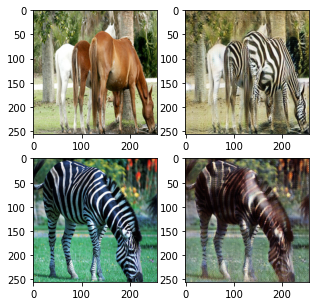

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


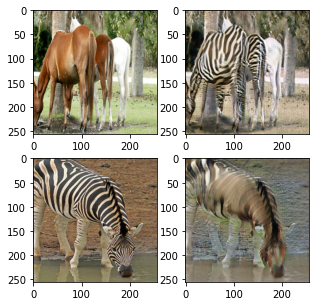


---------------------------------------------------------------------------------------------------
Epoch: 100	Time: 654.7450	Generator Loss: 7.9743	Discriminator LOSS: 0.3158	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 101	Time: 561.8145	Generator Loss: 7.9529	Discriminator LOSS: 0.3051	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 102	Time: 527.4897	Generator Loss: 7.9102	Discriminator LOSS: 0.2970	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 103	Time: 515.1859	Generator Loss: 7.8927	Discrim

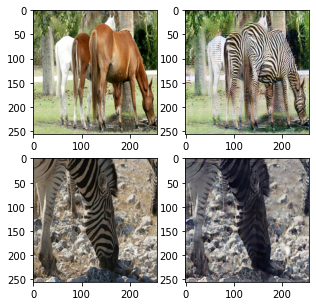

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


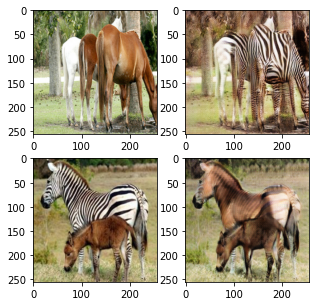


---------------------------------------------------------------------------------------------------
Epoch: 110	Time: 512.5443	Generator Loss: 7.6815	Discriminator LOSS: 0.2830	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 111	Time: 512.1045	Generator Loss: 7.6653	Discriminator LOSS: 0.2832	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 112	Time: 512.0262	Generator Loss: 7.6310	Discriminator LOSS: 0.2822	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 113	Time: 511.9433	Generator Loss: 7.6105	Discrim

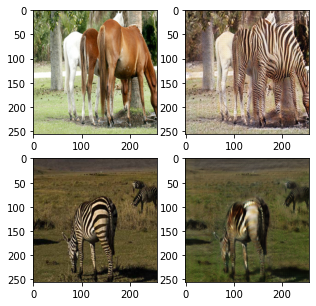

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


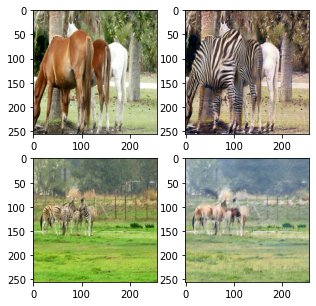


---------------------------------------------------------------------------------------------------
Epoch: 120	Time: 512.7062	Generator Loss: 7.5469	Discriminator LOSS: 0.2598	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 121	Time: 511.7852	Generator Loss: 7.5033	Discriminator LOSS: 0.2545	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 122	Time: 511.7767	Generator Loss: 7.4873	Discriminator LOSS: 0.2607	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 123	Time: 511.5170	Generator Loss: 7.4931	Discrim

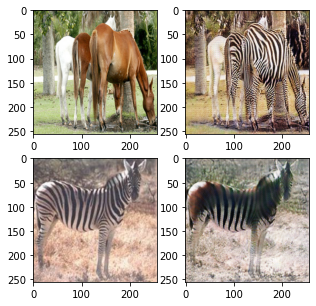

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


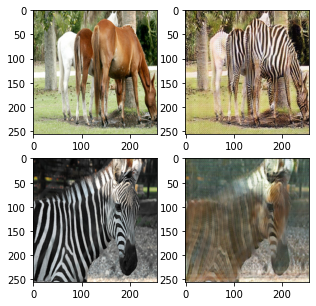


---------------------------------------------------------------------------------------------------
Epoch: 130	Time: 511.9183	Generator Loss: 7.4310	Discriminator LOSS: 0.2523	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 131	Time: 510.4793	Generator Loss: 7.4073	Discriminator LOSS: 0.2362	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 132	Time: 510.4937	Generator Loss: 7.4796	Discriminator LOSS: 0.2314	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 133	Time: 511.4373	Generator Loss: 7.3779	Discrim

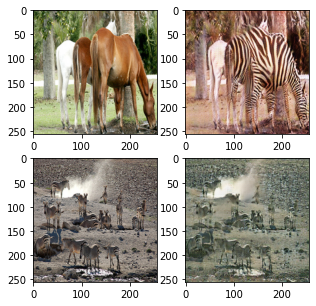

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


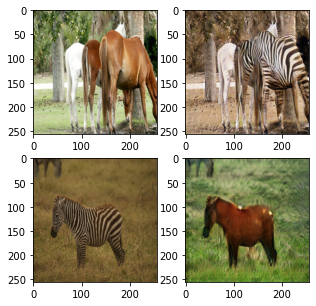


---------------------------------------------------------------------------------------------------
Epoch: 140	Time: 512.1382	Generator Loss: 7.3505	Discriminator LOSS: 0.2256	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 141	Time: 511.0885	Generator Loss: 7.3570	Discriminator LOSS: 0.2225	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 142	Time: 511.3699	Generator Loss: 7.3410	Discriminator LOSS: 0.2216	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 143	Time: 511.3874	Generator Loss: 7.3552	Discrim

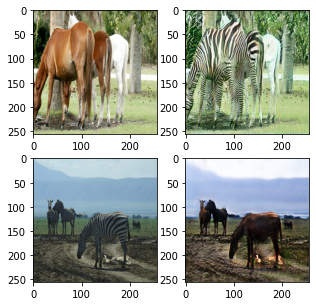

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


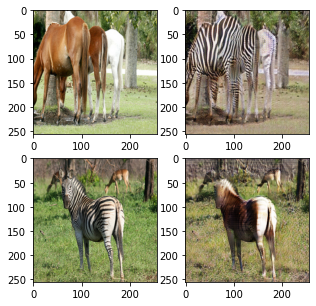


---------------------------------------------------------------------------------------------------
Epoch: 150	Time: 511.9669	Generator Loss: 7.3218	Discriminator LOSS: 0.2093	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 151	Time: 511.3255	Generator Loss: 7.3142	Discriminator LOSS: 0.2070	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 152	Time: 511.3102	Generator Loss: 7.3354	Discriminator LOSS: 0.2082	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 153	Time: 511.2781	Generator Loss: 7.2908	Discrim

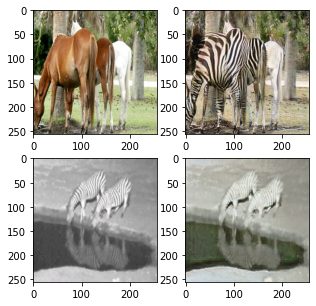

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


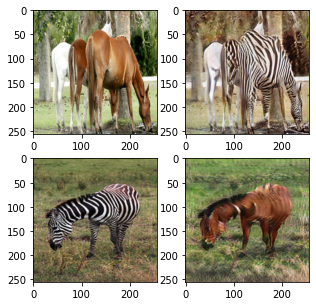


---------------------------------------------------------------------------------------------------
Epoch: 160	Time: 511.2415	Generator Loss: 7.3021	Discriminator LOSS: 0.1949	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 161	Time: 510.6052	Generator Loss: 7.3074	Discriminator LOSS: 0.1915	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 162	Time: 510.5330	Generator Loss: 7.2563	Discriminator LOSS: 0.1987	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 163	Time: 510.8493	Generator Loss: 7.2682	Discrim

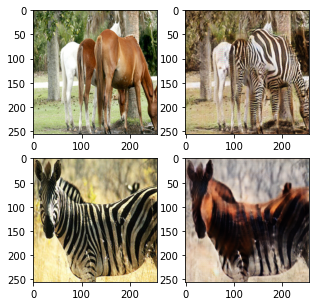

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


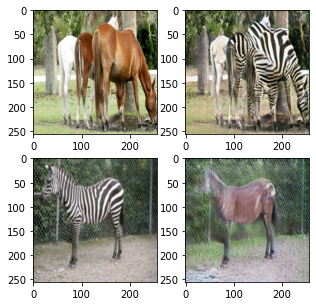


---------------------------------------------------------------------------------------------------
Epoch: 170	Time: 511.9342	Generator Loss: 7.2478	Discriminator LOSS: 0.1844	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 171	Time: 511.1561	Generator Loss: 7.2685	Discriminator LOSS: 0.1796	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 172	Time: 511.4697	Generator Loss: 7.2613	Discriminator LOSS: 0.1837	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 173	Time: 511.1668	Generator Loss: 7.2695	Discrim

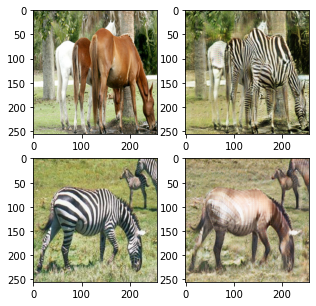

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


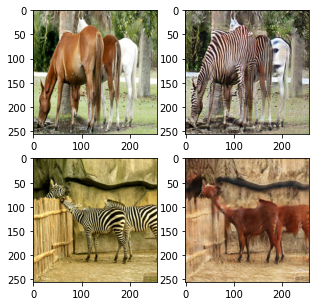


---------------------------------------------------------------------------------------------------
Epoch: 180	Time: 511.5253	Generator Loss: 7.2309	Discriminator LOSS: 0.1720	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 181	Time: 510.8885	Generator Loss: 7.2312	Discriminator LOSS: 0.1714	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 182	Time: 511.0256	Generator Loss: 7.2533	Discriminator LOSS: 0.1667	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 183	Time: 510.2582	Generator Loss: 7.2592	Discrim

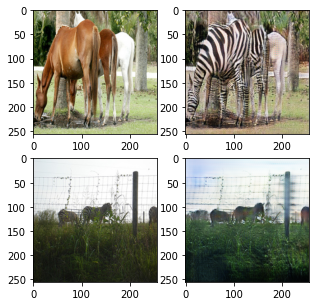

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


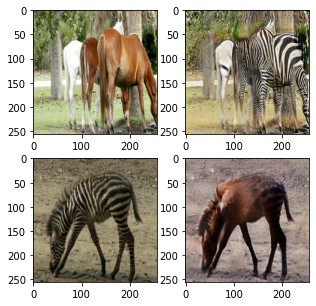


---------------------------------------------------------------------------------------------------
Epoch: 190	Time: 511.9993	Generator Loss: 7.2024	Discriminator LOSS: 0.1599	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 191	Time: 511.2297	Generator Loss: 7.2373	Discriminator LOSS: 0.1599	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 192	Time: 510.8094	Generator Loss: 7.2287	Discriminator LOSS: 0.1545	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 193	Time: 511.3166	Generator Loss: 7.2326	Discrim

In [ ]:
#Custom1
#feature loss 추가
import argparse
import itertools
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

import numpy as np



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_ch=3
output_ch=3
batch_size=1
n_epochs=200




netG_A2B,netG_B2A,netD_A,netD_B, optimizer_G,optimizer_D_A,optimizer_D_B, start_epoch=Custom1GAN(ckpt_dir)


# Losses
criterion_GAN =torch.nn.MSELoss()
criterion_cycle=torch.nn.L1Loss()
criterion_identity=torch.nn.L1Loss()

#feature loss +
criterion_feat = nn.HingeEmbeddingLoss()


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, 0, 5).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs,0,5).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, 0, 5).step)


#Input & targets memory allocation
Tensor = torch.cuda.FloatTensor

input_A=Tensor(batch_size,input_ch,256,256)
input_B=Tensor(batch_size,output_ch,256,256)
target_real=Variable(Tensor(batch_size).fill_(1.0),requires_grad=False)
target_fake=Variable(Tensor(batch_size).fill_(0.0),requires_grad=False)

#ReplayBuffer => 안정성 개선 (generator가 만든 사진을 다시 discriminator한테 보여줌.discriminator한테만 적용)
fake_A_buffer=ReplayBuffer()
fake_B_buffer=ReplayBuffer()


#Dataset
transforms_ = [ transforms.Resize(int(256*1.12), Image.BICUBIC), 
                transforms.RandomCrop(256), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset('/content/drive/MyDrive/datasets/horse2zebra/', transforms_=transforms_, unaligned=True), 
                        batch_size=batch_size, shuffle=True)



writer = SummaryWriter('/content/drive/MyDrive/Custom1GAN/scalar/')

for epoch in range(start_epoch,n_epochs):
  epoch_start_time=time.time()
  losses_g=[]
  losses_d=[]
  img_list=[]
  loss_cycle=[]
  loss_identity=[]
  loss_GAN=[]
  loss_feat=[]

  for i,batch in enumerate(dataloader):
    

    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Discriminator 진짜를 진짜로 예측하기
    netD_A.eval()
    netD_B.eval()
    _,real_feat_A = netD_A(real_A.detach())
    _,real_feat_B = netD_B(real_B.detach())

    netD_A.train()
    netD_B.train()


    #############################################   Gernerator  #############################################
    optimizer_G.zero_grad()
    
    #####  Identity loss  #####

    #말->얼룩말 G모델(A2B) 에 얼룩말 넣으면 얼룩말이 결과로 나와야돼
    same_B = netG_A2B(real_B)
    loss_identity_B= criterion_identity(same_B,real_B)*5.0

    #얼룩말->말 G모델(B2A) 에 말 넣으면 말이 결과로 나와야돼
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A,real_A)*5.0

    ###########################



    #####  GAN loss  ##### => 단방향 끼리 loss 
    fake_B = netG_A2B(real_A) #진짜 말로 가짜 얼룩말 생성
    pred_fake_B,fake_feat_B= netD_B(fake_B) #가짜 말 예측 라벨값
    loss_GAN_A2B = criterion_GAN(pred_fake_B,target_real)

    fake_A = netG_B2A(real_B) #진짜 얼룩말로 가짜 말 생성
    pred_fake_A,fake_feat_A = netD_A(fake_A) #가짜말 예측 라벨값
    loss_GAN_B2A = criterion_GAN(pred_fake_A,target_real)
    
    ###########################



    #####  Cycle loss ##### 
    recovered_A =netG_B2A(fake_B)
    loss_cycle_ABA=criterion_cycle(recovered_A,real_A)*10.0
    
    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB=criterion_cycle(recovered_B, real_B)*10.0

    ###########################

    #####  Feature loss ##### 
    loss_fm_B = get_fm_loss( real_feat_B, fake_feat_B, criterion_feat )
    loss_fm_A = get_fm_loss( real_feat_A, fake_feat_A, criterion_feat )

    ###########################


    #텐서보드 위해
    loss_identity.append(loss_identity_A + loss_identity_B)
    loss_cycle.append(loss_cycle_ABA + loss_cycle_BAB)
    loss_GAN.append(loss_GAN_A2B + loss_GAN_B2A)
    loss_feat.append(loss_fm_B + loss_fm_A)
    #

    

    # Total loss
    loss_G = loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB +(loss_GAN_A2B + loss_GAN_B2A)+(loss_fm_B + loss_fm_A)
    loss_G.backward()
    optimizer_G.step()


    ########################################################



    #############################################   Discriminator A  #############################################

    optimizer_D_A.zero_grad()

    pred_real_A,_ = netD_A(real_A)


    # Real loss
    loss_D_real = criterion_GAN(pred_real_A, target_real)

    # Fake loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake,_ = netD_A(fake_A.detach()) #generator 학습시키지 않기 위해 detach => backpropagation해도 fake_A의 requires_grad가 false 이므로 model_g에 영향 안미침
    loss_D_fake = criterion_GAN(pred_fake,target_fake) #가짜 들어오면 가짜로 

    # Total loss
    loss_D_A = (loss_D_real + loss_D_fake)*0.5
    loss_D_A.backward()

    optimizer_D_A.step()

    ##############################################


    #############################################   Discriminator B  #############################################

    optimizer_D_B.zero_grad()

    pred_real_B,_ = netD_B(real_B)

    # Real loss
    loss_D_real = criterion_GAN(pred_real_B, target_real)

    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake,_ = netD_B(fake_B.detach()) #generator 학습시키지 않기 위해 detach => backpropagation해도 fake_A의 requires_grad가 false 이므로 model_g에 영향 안미침
    loss_D_fake = criterion_GAN(pred_fake,target_fake) #가짜 들어오면 가짜로 

    # Total loss
    loss_D_B = (loss_D_real + loss_D_fake)*0.5
    loss_D_B.backward()

    optimizer_D_B.step()

    ##############################################3
    


    losses_d.append(loss_D_A+loss_D_B)
    losses_g.append(loss_G)

    if epoch % 10==0 and batch['A_name'][0]=='/content/drive/MyDrive/datasets/horse2zebra/trainA/n02381460_1405.jpg':
      with torch.no_grad():
            # Generate output
        fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
        fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
        real_A = 0.5*(real_A.data+1.0)
        real_B = 0.5*(real_B.data+1.0)
        img_list=[real_A,fake_B,real_B,fake_A]

        custom_imshow(img_list)
      



  epoch_loss_G=sum(losses_g)/len(losses_g)
  epoch_loss_D=sum(losses_d)/len(losses_d)
  epoch_loss_identity=sum(loss_identity)/len(loss_identity)
  epoch_loss_GAN=sum(loss_GAN)/len(loss_GAN)
  epoch_loss_cycle=sum(loss_cycle)/len(loss_cycle)
  writer.add_scalar('loss_G/train',epoch_loss_G, epoch)
  writer.add_scalar('loss_G_identity/train',epoch_loss_identity, epoch)
  writer.add_scalar('loss_G_GAN/train',epoch_loss_GAN, epoch)
  writer.add_scalar('loss_G_cycle/train',epoch_loss_cycle, epoch)
  writer.add_scalar('loss_D/train',epoch_loss_D, epoch)

  save(ckpt_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B,epoch)
  # if epoch>2:
  #   os.remove('%s/model_epoch%d.pth'%(ckpt_dir,epoch-5))
  
  print("\n---------------------------------------------------------------------------------------------------")
  print("Epoch: {}\tTime: {:.4f}\tGenerator Loss: {:.4f}\tDiscriminator LOSS: {:.4f}\t".format(epoch, time.time()-epoch_start_time,  epoch_loss_G,epoch_loss_D))
  print("------------------------------------------------------------------------------------------------------")
  
  
    

  

  #Update learning rates
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()






writer.close()





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



---------------------------------------------------------------------------------------------------
Epoch: 147	Time: 1326.7634	Generator Loss: 3.8518	Discriminator LOSS: 0.2252	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 148	Time: 625.7154	Generator Loss: 3.8010	Discriminator LOSS: 0.2307	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 149	Time: 551.8701	Generator Loss: 3.8610	Discriminator LOSS: 0.2188	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 150	Time: 517.7523	Generator Loss: 3.8185	Discri

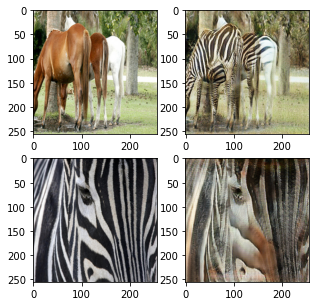

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


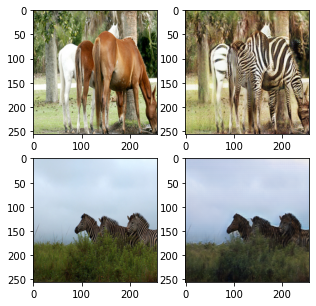


---------------------------------------------------------------------------------------------------
Epoch: 160	Time: 499.0306	Generator Loss: 3.7648	Discriminator LOSS: 0.2091	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 161	Time: 498.1689	Generator Loss: 3.7954	Discriminator LOSS: 0.2022	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 162	Time: 498.0859	Generator Loss: 3.7649	Discriminator LOSS: 0.2037	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 163	Time: 498.1304	Generator Loss: 3.7732	Discrim

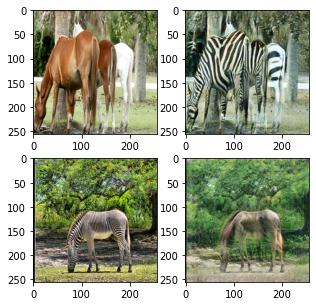

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


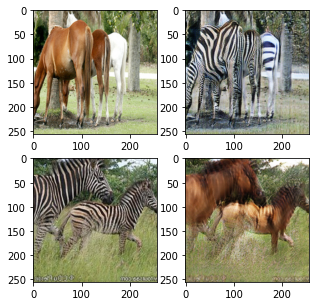


---------------------------------------------------------------------------------------------------
Epoch: 180	Time: 499.5925	Generator Loss: 3.6935	Discriminator LOSS: 0.1748	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 181	Time: 498.4651	Generator Loss: 3.6701	Discriminator LOSS: 0.1788	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 182	Time: 498.1041	Generator Loss: 3.6800	Discriminator LOSS: 0.1771	
------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Epoch: 183	Time: 498.1450	Generator Loss: 3.6399	Discrim

In [ ]:
#CycleGAN

import argparse
import itertools
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

import numpy as np




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_ch=3
output_ch=3
batch_size=1
n_epochs=200





netG_A2B,netG_B2A,netD_A,netD_B, optimizer_G,optimizer_D_A,optimizer_D_B, start_epoch=CycleGAN(ckpt_dir)



# Losses
criterion_GAN =torch.nn.MSELoss()
criterion_cycle=torch.nn.L1Loss()
criterion_identity=torch.nn.L1Loss()



lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, 0, 5).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs,0,5).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, 0, 5).step)


#Input & targets memory allocation
Tensor = torch.cuda.FloatTensor

input_A=Tensor(batch_size,input_ch,256,256)
input_B=Tensor(batch_size,output_ch,256,256)
target_real=Variable(Tensor(batch_size).fill_(1.0),requires_grad=False)
target_fake=Variable(Tensor(batch_size).fill_(0.0),requires_grad=False)

#ReplayBuffer => 안정성 개선 (generator가 만든 사진을 다시 discriminator한테 보여줌.discriminator한테만 적용)
fake_A_buffer=ReplayBuffer()
fake_B_buffer=ReplayBuffer()


#Dataset
transforms_ = [ transforms.Resize(int(256*1.12), Image.BICUBIC), 
                transforms.RandomCrop(256), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset('/content/drive/MyDrive/datasets/horse2zebra/', transforms_=transforms_, unaligned=True), 
                        batch_size=batch_size, shuffle=True)



writer = SummaryWriter('/content/drive/MyDrive/CycleGAN/scalar/')

for epoch in range(start_epoch,n_epochs):
  epoch_start_time=time.time()
  losses_g=[]
  losses_d=[]
  img_list=[]
  loss_cycle=[]
  loss_identity=[]
  loss_GAN=[]

  for i,batch in enumerate(dataloader):
    

    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))


    #############################################   Gernerator  #############################################
    optimizer_G.zero_grad()
    
    #####  Identity loss  #####

    #말->얼룩말 G모델(A2B) 에 얼룩말 넣으면 얼룩말이 결과로 나와야돼
    same_B = netG_A2B(real_B)
    loss_identity_B= criterion_identity(same_B,real_B)*5.0

    #얼룩말->말 G모델(B2A) 에 말 넣으면 말이 결과로 나와야돼
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A,real_A)*5.0

    ###########################



    #####  GAN loss  ##### => 단방향 끼리 loss 
    fake_B = netG_A2B(real_A) #진짜 말로 가짜 얼룩말 생성
    pred_fake= netD_B(fake_B) #가짜 말 예측 라벨값
    loss_GAN_A2B = criterion_GAN(pred_fake,target_real)

    fake_A = netG_B2A(real_B) #진짜 얼룩말로 가짜 말 생성
    pred_fake = netD_A(fake_A) #가짜말 예측 라벨값
    loss_GAN_B2A = criterion_GAN(pred_fake,target_real)
    
    ###########################



    #####  Cycle loss ##### => 양방향 loss..?
    recovered_A =netG_B2A(fake_B)
    loss_cycle_ABA=criterion_cycle(recovered_A,real_A)*10.0
    
    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB=criterion_cycle(recovered_B, real_B)*10.0

    ###########################
    #텐서보드 위해
    loss_identity.append(loss_identity_A + loss_identity_B)
    loss_cycle.append(loss_cycle_ABA + loss_cycle_BAB)
    loss_GAN.append(loss_GAN_A2B + loss_GAN_B2A)
    #

    

    # Total loss
    loss_G = loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB +loss_GAN_A2B + loss_GAN_B2A
    loss_G.backward()
    optimizer_G.step()


    ########################################################



    #############################################   Discriminator A  #############################################

    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(real_A) #진짜를 진짜로 예측하기
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake = netD_A(fake_A.detach()) #generator 학습시키지 않기 위해 detach => backpropagation해도 fake_A의 requires_grad가 false 이므로 model_g에 영향 안미침
    loss_D_fake = criterion_GAN(pred_fake,target_fake) #가짜 들어오면 가짜로 

    # Total loss
    loss_D_A = (loss_D_real + loss_D_fake)*0.5
    loss_D_A.backward()

    optimizer_D_A.step()

    ##############################################


    #############################################   Discriminator B  #############################################

    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B) #진짜를 진짜로 예측하기
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake = netD_B(fake_B.detach()) #generator 학습시키지 않기 위해 detach => backpropagation해도 fake_A의 requires_grad가 false 이므로 model_g에 영향 안미침
    loss_D_fake = criterion_GAN(pred_fake,target_fake) #가짜 들어오면 가짜로 

    # Total loss
    loss_D_B = (loss_D_real + loss_D_fake)*0.5
    loss_D_B.backward()

    optimizer_D_B.step()

    ##############################################3
    


    losses_d.append(loss_D_A+loss_D_B)
    losses_g.append(loss_G)

    if epoch % 20==0 and batch['A_name'][0]=='/content/drive/MyDrive/datasets/horse2zebra/trainA/n02381460_1405.jpg':
      with torch.no_grad():
            # Generate output
        fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
        fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
        real_A = 0.5*(real_A.data+1.0)
        real_B = 0.5*(real_B.data+1.0)
        img_list=[real_A,fake_B,real_B,fake_A]

        custom_imshow(img_list)
      



  epoch_loss_G=sum(losses_g)/len(losses_g)
  epoch_loss_D=sum(losses_d)/len(losses_d)
  epoch_loss_identity=sum(loss_identity)/len(loss_identity)
  epoch_loss_GAN=sum(loss_GAN)/len(loss_GAN)
  epoch_loss_cycle=sum(loss_cycle)/len(loss_cycle)
  writer.add_scalar('loss_G/train',epoch_loss_G, epoch)
  writer.add_scalar('loss_G_identity/train',epoch_loss_identity, epoch)
  writer.add_scalar('loss_G_GAN/train',epoch_loss_GAN, epoch)
  writer.add_scalar('loss_G_cycle/train',epoch_loss_cycle, epoch)
  writer.add_scalar('loss_D/train',epoch_loss_D, epoch)

  save(ckpt_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B,epoch)
  # os.remove('%s/model_epoch%d.pth'%(ckpt_dir,epoch-1))
  
  print("\n---------------------------------------------------------------------------------------------------")
  print("Epoch: {}\tTime: {:.4f}\tGenerator Loss: {:.4f}\tDiscriminator LOSS: {:.4f}\t".format(epoch, time.time()-epoch_start_time,  epoch_loss_G,epoch_loss_D))
  print("------------------------------------------------------------------------------------------------------")
  
  
    

  

  #Update learning rates
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()






writer.close()





In [ ]:
#Orange
#CycleGAN

import argparse
import itertools
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

import numpy as np




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_ch=3
output_ch=3
batch_size=1
n_epochs=200





netG_A2B,netG_B2A,netD_A,netD_B, optimizer_G,optimizer_D_A,optimizer_D_B, start_epoch=CycleGAN(ckpt_dir)



# Losses
criterion_GAN =torch.nn.MSELoss()
criterion_cycle=torch.nn.L1Loss()
criterion_identity=torch.nn.L1Loss()



lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, 0, 5).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs,0,5).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, 0, 5).step)


#Input & targets memory allocation
Tensor = torch.cuda.FloatTensor

input_A=Tensor(batch_size,input_ch,256,256)
input_B=Tensor(batch_size,output_ch,256,256)
target_real=Variable(Tensor(batch_size).fill_(1.0),requires_grad=False)
target_fake=Variable(Tensor(batch_size).fill_(0.0),requires_grad=False)

#ReplayBuffer => 안정성 개선 (generator가 만든 사진을 다시 discriminator한테 보여줌.discriminator한테만 적용)
fake_A_buffer=ReplayBuffer()
fake_B_buffer=ReplayBuffer()


#Dataset
transforms_ = [ transforms.Resize(int(256*1.12), Image.BICUBIC), 
                transforms.RandomCrop(256), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset('/content/drive/MyDrive/datasets2/apple2orange/', transforms_=transforms_, unaligned=True), 
                        batch_size=batch_size, shuffle=True)



writer = SummaryWriter('/content/drive/MyDrive/CycleGAN/apple2orange/scalar/')

for epoch in range(start_epoch,n_epochs):
  epoch_start_time=time.time()
  losses_g=[]
  losses_d=[]
  img_list=[]
  loss_cycle=[]
  loss_identity=[]
  loss_GAN=[]

  for i,batch in enumerate(dataloader):
    

    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))


    #############################################   Gernerator  #############################################
    optimizer_G.zero_grad()
    
    #####  Identity loss  #####

    #말->얼룩말 G모델(A2B) 에 얼룩말 넣으면 얼룩말이 결과로 나와야돼
    same_B = netG_A2B(real_B)
    loss_identity_B= criterion_identity(same_B,real_B)*5.0

    #얼룩말->말 G모델(B2A) 에 말 넣으면 말이 결과로 나와야돼
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A,real_A)*5.0

    ###########################



    #####  GAN loss  ##### => 단방향 끼리 loss 
    fake_B = netG_A2B(real_A) #진짜 말로 가짜 얼룩말 생성
    pred_fake= netD_B(fake_B) #가짜 말 예측 라벨값
    loss_GAN_A2B = criterion_GAN(pred_fake,target_real)

    fake_A = netG_B2A(real_B) #진짜 얼룩말로 가짜 말 생성
    pred_fake = netD_A(fake_A) #가짜말 예측 라벨값
    loss_GAN_B2A = criterion_GAN(pred_fake,target_real)
    
    ###########################



    #####  Cycle loss ##### => 양방향 loss..?
    recovered_A =netG_B2A(fake_B)
    loss_cycle_ABA=criterion_cycle(recovered_A,real_A)*10.0
    
    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB=criterion_cycle(recovered_B, real_B)*10.0

    ###########################
    #텐서보드 위해
    loss_identity.append(loss_identity_A + loss_identity_B)
    loss_cycle.append(loss_cycle_ABA + loss_cycle_BAB)
    loss_GAN.append(loss_GAN_A2B + loss_GAN_B2A)
    #

    

    # Total loss
    loss_G = loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB +loss_GAN_A2B + loss_GAN_B2A
    loss_G.backward()
    optimizer_G.step()


    ########################################################



    #############################################   Discriminator A  #############################################

    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(real_A) #진짜를 진짜로 예측하기
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake = netD_A(fake_A.detach()) #generator 학습시키지 않기 위해 detach => backpropagation해도 fake_A의 requires_grad가 false 이므로 model_g에 영향 안미침
    loss_D_fake = criterion_GAN(pred_fake,target_fake) #가짜 들어오면 가짜로 

    # Total loss
    loss_D_A = (loss_D_real + loss_D_fake)*0.5
    loss_D_A.backward()

    optimizer_D_A.step()

    ##############################################


    #############################################   Discriminator B  #############################################

    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B) #진짜를 진짜로 예측하기
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake = netD_B(fake_B.detach()) #generator 학습시키지 않기 위해 detach => backpropagation해도 fake_A의 requires_grad가 false 이므로 model_g에 영향 안미침
    loss_D_fake = criterion_GAN(pred_fake,target_fake) #가짜 들어오면 가짜로 

    # Total loss
    loss_D_B = (loss_D_real + loss_D_fake)*0.5
    loss_D_B.backward()

    optimizer_D_B.step()

    ##############################################3
    


    losses_d.append(loss_D_A+loss_D_B)
    losses_g.append(loss_G)

    if epoch % 20==0 and batch['A_name'][0]=='/content/drive/MyDrive/datasets2/apple2orange/trainA/n07740461_1164.jpg':
      with torch.no_grad():
            # Generate output
        fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
        fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
        real_A = 0.5*(real_A.data+1.0)
        real_B = 0.5*(real_B.data+1.0)
        img_list=[real_A,fake_B,real_B,fake_A]

        custom_imshow(img_list)
      



  epoch_loss_G=sum(losses_g)/len(losses_g)
  epoch_loss_D=sum(losses_d)/len(losses_d)
  epoch_loss_identity=sum(loss_identity)/len(loss_identity)
  epoch_loss_GAN=sum(loss_GAN)/len(loss_GAN)
  epoch_loss_cycle=sum(loss_cycle)/len(loss_cycle)
  writer.add_scalar('loss_G/train',epoch_loss_G, epoch)
  writer.add_scalar('loss_G_identity/train',epoch_loss_identity, epoch)
  writer.add_scalar('loss_G_GAN/train',epoch_loss_GAN, epoch)
  writer.add_scalar('loss_G_cycle/train',epoch_loss_cycle, epoch)
  writer.add_scalar('loss_D/train',epoch_loss_D, epoch)

  save(ckpt_dir,netG_A2B,netG_B2A,netD_A,netD_B,optimizer_G,optimizer_D_A,optimizer_D_B,epoch)
  # if epoch>2:
  #   os.remove('%s/model_epoch%d.pth'%(ckpt_dir,epoch-1))
  
  print("\n---------------------------------------------------------------------------------------------------")
  print("Epoch: {}\tTime: {:.4f}\tGenerator Loss: {:.4f}\tDiscriminator LOSS: {:.4f}\t".format(epoch, time.time()-epoch_start_time,  epoch_loss_G,epoch_loss_D))
  print("------------------------------------------------------------------------------------------------------")
  
  
    

  

  #Update learning rates
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()






writer.close()





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#Test

In [ ]:

import argparse
import sys
import os

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch


###### Definition of variables ######
input_ch=3
output_ch=3

#netG_A2B,netG_B2A,netD_A,netD_B, optimizer_G,optimizer_D_A,optimizer_D_B, start_epoch=CycleGAN(ckpt_dir)
netG_A2B,netG_B2A,netD_A,netD_B, optimizer_G,optimizer_D_A,optimizer_D_B, start_epoch=Custom1GAN(ckpt_dir)

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor
input_A = Tensor(1,3,256,256)
input_B = Tensor(1,3,256,256)

# Dataset loader
transforms_ = [ transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset('/content/drive/MyDrive/datasets/horse2zebra/', transforms_=transforms_, mode='test'), 
                        batch_size=1, shuffle=False)
###################################

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists(os.path.join(data_dir+'/A')):
    os.makedirs(os.path.join(data_dir+'/A'))
if not os.path.exists(os.path.join(data_dir+'/B')):
    os.makedirs(os.path.join(data_dir+'/B'))

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, os.path.join(data_dir+'/A/%04d.png' % (i+1)))
    save_image(fake_B, os.path.join(data_dir+'/B/%04d.png' % (i+1)))

###################################

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


Temp

In [ ]:
import torch 
import torchvision 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt 
import numpy as np
import os

root='/content/drive/MyDrive/datasets/horse2zebra/'
mode='train'


files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))


for i,name in enumerate(files_A):
  a=plt.imread(os.path.join(files_A[i]))
  # print(len(a.shape))
  # print(files_B[i])
  if len(a.shape)!=3:
    print('hello')
    print(files_A[i])
    os.remove(files_A[i])



for i,name in enumerate(files_B):
  a=plt.imread(os.path.join(files_B[i]))
  # print(len(a.shape))
  # print(files_B[i])
  if len(a.shape)!=3:
    print('hello')
    print(files_B[i])
    os.remove(files_B[i])


  

In [ ]:
from torchsummary import summary

model1=Discriminator(3).cpu()
model2=Generator(3,3).cpu()
model3=ResidualBlock(3).cpu()

summary(model2,input_size=(3,256,256),device='cpu')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

['/content/drive/MyDrive/datasets/horse2zebra/trainA/n02381460_3556.jpg']


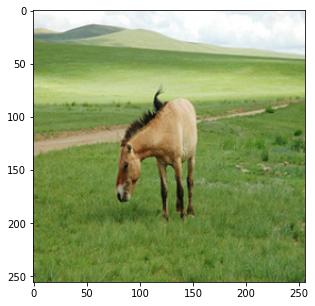

In [ ]:

for i,batch in enumerate(dataloader):
  print(batch['A_name'])
  a=batch['A_name'][0]
  img = batch['A'].detach().cpu().numpy() 
  img=(img+1)*0.5
  img=img.squeeze()
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(img, (1, 2, 0))) 
  plt.show()
  break
